<a href="https://colab.research.google.com/github/g185/AMLrepository/blob/main/Final_AML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Download and unzip Dataset***


*   Create folders
*   Download Recipe 5K + Annotations in drive
*   Unzip files in folder



In [ ]:
#Create folders for models and datasets
!mkdir "/content/drive/My Drive/RecipeNet" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/download" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/extracted" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/preprocessed" 
!mkdir "/content/drive/My Drive/RecipeNet/model" 

#Scarica dataset
#Trascina i 3 zip

#Unzip
"""
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/new_right_train.zip" -d "/content/drive/My Drive/RecipeNet_g/datasets/extracted"
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/archive.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/Ingredients101.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"

"""


#***Imports and Drive Mount***

In [1]:
#Imports
import sys
import time
import os
import json
import numpy as np 
import pandas as pd 
from tqdm.notebook import tqdm, trange
import sys
import cv2
import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from glob import glob
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict


#Cuda
device = torch.device("cuda")
torch.manual_seed(42) # try and make the results more reproducible
print(torch.cuda.get_device_name(0))

#Drive Mount
from google.colab import drive
drive.mount('/content/drive')


Tesla P100-PCIE-16GB
Mounted at /content/drive


#***Project Parameters***


In [2]:
params = {}

#DATASET KEYWORD
params["dataset"] = "Recipe1M"

#NEURAL NETWORK PARAMS
params["freezed_layers"] = 8

#GENERAL TRAINING PARAMS
params["epochs"] = 8
params["batch_size"] = 64
params["img_size"] = (384,384)

#FAST TRAINING SETTINGS
params["fast_training"] = True
params["train_df_size"] = 6700
params["val_df_size"] = 540
params["test_df_size"] = 2700

#DATASET SETTINGS
params["root"] = "/content/drive/My Drive/RecipeNet/"
if params["dataset"] == "Recipe5k":
    params["images_dir"] = params["root"] + "datasets/extracted/images/" 
    params["ingredients_per_class"] = params["root"] + "datasets/extracted/Ingredients101/Annotations/ingredients_simplified.txt" 
    params["classes"] = params["root"] + "datasets/extracted/Ingredients101/Annotations/classes.txt" 
    params["baseIngredients_dir"] = params["root"] + "datasets/extracted/Ingredients101/ingredients_simplification/baseIngredients.txt" 
    params["annotations_path"] = params["root"] + "datasets/extracted/Ingredients101/Annotations/"
elif params["dataset"] == "Recipe1M":
    params["images_dir"] = params["root"] + "datasets/extracted/new_right_train/" 
    params["annotations_path"] = params["root"] + "datasets/extracted/Annotations_1M/"
    params["ingredients_per_class"] = params["root"] + "datasets/extracted/Annotations_1M/ingr.txt" 
    params["classes"] = params["root"] + "datasets/extracted/Annotations_1M/newclasses.txt" 
    params["baseIngredients_dir"] = params["root"] + "datasets/extracted/Annotations_1M/baseIngredients.txt" 
    params["annotations_path"] = params["root"] + "datasets/extracted/Annotations_1M/"
else:
    print("Invalid Dataset Keyword, try with Recipe1M or Recipe5k")


#***Data extraction and preprocessing***


Dataset Loading

In [3]:
#Ingredients x class
f = open(params["ingredients_per_class"], "r")
ingredients = f.read().split('\n')
f.close()

#Classes
f = open(params["classes"], "r")
classes = f.read().split('\n')
f.close()

#Ingredients
f = open(params["baseIngredients_dir"], "r")
base_ing = f.read().split('\n')
base_ing = base_ing[0].split(",")
f.close()

#train images
f = open(params["root"] + "datasets/extracted/Annotations_1M/train_imgs.txt", "r")
train_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Annotations_1M/train_lab.txt", "r")
train_labels = f.read().split('\n')
f.close()

#validation images
f = open(params["root"] + "datasets/extracted/Annotations_1M/val_imgs.txt", "r")
val_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Annotations_1M/val_lab.txt", "r")
val_labels = f.read().split('\n')
f.close()

#test images
f = open(params["root"] + "datasets/extracted/Annotations_1M/test_imgs.txt", "r")
test_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Annotations_1M/test_lab.txt", "r")
test_labels = f.read().split('\n')
f.close()

Dataframes Creation

In [4]:
#list of string in list of list of tokens
new_ingredients = [arr.split(",") for arr in ingredients]

#binary encode ingredients
mlb = MultiLabelBinarizer()
df = pd.DataFrame(mlb.fit_transform(new_ingredients),columns=mlb.classes_) 
df["target"] = classes
food_dict = df
train_images = [params["images_dir"] + s + ".jpg" for s in train_images]
all_img_df = pd.DataFrame({'path': train_images, 'class_id': train_labels})
val_images = [params["images_dir"] + s + ".jpg" for s in val_images]
val_img_df = pd.DataFrame({'path': val_images, 'class_id': val_labels})
test_images = [params["images_dir"] + s + ".jpg" for s in test_images]
test_img_df = pd.DataFrame({'path': test_images, 'class_id': test_labels})
all_img_df = all_img_df[:-1]
val_img_df = val_img_df[:-1]
test_img_df = test_img_df[:-1]



all_img_df['class_name'] = all_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
val_img_df['class_name'] = val_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
test_img_df['class_name'] = test_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])

#food_dict = food_dict.drop('', 1)


Train Dataframe

In [5]:
#Dataframe for train images
new_data = []
for index, row in all_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = class_id
    #print(binary_encod["class_id"])
    #print((list(binary_encod.columns.values)))
    #print(len(np.array(binary_encod)[0]))
    new_data.append(np.array(binary_encod)[0])


    
col_names = list(binary_encod.columns.values)
train_df = pd.DataFrame(new_data, columns = col_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Validation Dataframe

In [6]:
val_data = []
for index, row in val_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = int(class_id)
    val_data.append(np.array(binary_encod)[0])
val_df = pd.DataFrame(val_data, columns = col_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Test Dataframe

In [7]:
test_data = []
for index, row in test_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = int(class_id)
    test_data.append(np.array(binary_encod)[0])


test_df = pd.DataFrame(test_data, columns = col_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


#***DataGenerator***


In [8]:
class DataWrapper(data.Dataset):
    ''' Data wrapper for pytorch's data loader function '''
    def __init__(self, image_df, resize):
        self.dataset = image_df
        self.resize = resize

    def __getitem__(self, index):
        c_row = self.dataset.iloc[index]
        target_arr = []
        for item in c_row[targets].values:
            target_arr.append(item)
        #print(target_arr)
        image_path, target = c_row['path'], torch.from_numpy(np.array(target_arr)).float()  #image and target
        #read as rgb image, resize and convert to range 0 to 1
        image = cv2.imread(image_path, 1)
        #print(image_path, image)
        if self.resize:
            image = cv2.resize(image, params["img_size"])/255.0 
        else:
            image = image/255.0
        image = (torch.from_numpy(image.transpose(2,0,1))).float() #NxCxHxW
        return image, target

    def __len__(self):
        return self.dataset.shape[0]

#***Trasfer Learning Model:ResNet***

In [9]:
col_names = list(train_df.columns.values)
targets = col_names[:-3]

model = models.resnet50(pretrained=True)

output = len(targets)
model.fc = nn.Linear(model.fc.in_features, output)

layer = 0
for name, child in model.named_children():
    layer += 1
    if layer < params["freezed_layers"]:
        for name2, param in child.named_parameters():
            param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


#***Trasfer Learning Model:GoogleNet***

#***Training***

Define Hamming Score

In [12]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

Training Settings

In [13]:
if params["fast_training"] == True:
    train_df = train_df[:6700]
    val_df = val_df[:540]
    test_df = test_df[:2700]
            
print(len(val_df))
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())



540


Dataset Loaders

In [14]:
train_dataset = DataWrapper(train_df, True)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True, batch_size=params["batch_size"], pin_memory=False)

val_dataset = DataWrapper(val_df, True)
val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=True, batch_size=params["batch_size"], pin_memory=False)

test_dataset = DataWrapper(test_df, True)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True, batch_size=params["batch_size"], pin_memory=False)

Training

Epoch  0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Training loss:  0.0011502545732838005  train acc:  0.9734106758782507


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test set accuracy:  0.980858806404658
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.44576581500830154], 'macro_train': [0.08467398470097941], 'weighted_train': [0.4637408562420599], 'hamming_train': [0.3811668949934688], 'samples_test': [0.5716872806223848], 'macro_test': [0.12536768480586744], 'weighted_test': [0.5781831011718448], 'hamming_test': [0.502782644310422]})
Epoch  1



Training loss:  0.0007539379396545354  train acc:  0.981913576223685



Test set accuracy:  0.9838508814491347
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.44576581500830154, 0.5849084564003816], 'macro_train': [0.08467398470097941, 0.16012668007495076], 'weighted_train': [0.4637408562420599, 0.6082228435006871], 'hamming_train': [0.3811668949934688, 0.5125625395358714], 'samples_test': [0.5716872806223848, 0.6399710833395456], 'macro_test': [0.12536768480586744, 0.1541652948091622], 'weighted_test': [0.5781831011718448, 0.6444901927026534], 'hamming_test': [0.502782644310422, 0.5735079411154402]})
Epoch  2



Training loss:  0.0006299379985056706  train acc:  0.9845779834452193



Test set accuracy:  0.9844573831473394
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.44576581500830154, 0.5849084564003816, 0.6568205386450143], 'macro_train': [0.08467398470097941, 0.16012668007495076, 0.2079036581852618], 'weighted_train': [0.4637408562420599, 0.6082228435006871, 0.683554513693027], 'hamming_train': [0.3811668949934688, 0.5125625395358714, 0.5848541362523618], 'samples_test': [0.5716872806223848, 0.6399710833395456, 0.6825236813134417], 'macro_test': [0.12536768480586744, 0.1541652948091622, 0.21778026432036598], 'weighted_test': [0.5781831011718448, 0.6444901927026534, 0.7042295820387228], 'hamming_test': [0.502782644310422, 0.5735079411154402, 0.6132326923178745]})
Epoch  3



Training loss:  0.00052552246085521  train acc:  0.9870507723391775



Test set accuracy:  0.9847646773410965
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.44576581500830154, 0.5849084564003816, 0.6568205386450143, 0.7145637842547296], 'macro_train': [0.08467398470097941, 0.16012668007495076, 0.2079036581852618, 0.2575302771541517], 'weighted_train': [0.4637408562420599, 0.6082228435006871, 0.683554513693027, 0.7464307184784359], 'hamming_train': [0.3811668949934688, 0.5125625395358714, 0.5848541362523618, 0.6436935152762923], 'samples_test': [0.5716872806223848, 0.6399710833395456, 0.6825236813134417, 0.6885448581717185], 'macro_test': [0.12536768480586744, 0.1541652948091622, 0.21778026432036598, 0.2164072642448933], 'weighted_test': [0.5781831011718448, 0.6444901927026534, 0.7042295820387228, 0.7011611901826259], 'hamming_test': [0.502782644310422, 0.5735079411154402, 0.6132326923178745, 0.6209589169732788]})
Epoch  4



Training loss:  0.00043439217217600167  train acc:  0.989187251515349



Test set accuracy:  0.9863254083778101
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.44576581500830154, 0.5849084564003816, 0.6568205386450143, 0.7145637842547296, 0.7681678124215633], 'macro_train': [0.08467398470097941, 0.16012668007495076, 0.2079036581852618, 0.2575302771541517, 0.29529557676433416], 'weighted_train': [0.4637408562420599, 0.6082228435006871, 0.683554513693027, 0.7464307184784359, 0.7970451547297284], 'hamming_train': [0.3811668949934688, 0.5125625395358714, 0.5848541362523618, 0.6436935152762923, 0.7015166140945632], 'samples_test': [0.5716872806223848, 0.6399710833395456, 0.6825236813134417, 0.6885448581717185, 0.6984326919836148], 'macro_test': [0.12536768480586744, 0.1541652948091622, 0.21778026432036598, 0.2164072642448933, 0.2384548211282244], 'weighted_test': [0.5781831011718448, 0.6444901927026534, 0.7042295820387228, 0.7011611901826259, 0.7325127961305542], 'hamming_test': [0.502782644310422, 0.5735079411154402, 0.6132326923178745, 0.6209589169


Training loss:  0.0003325684763379951  train acc:  0.9918549175519781



Test set accuracy:  0.9861070677664564
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.44576581500830154, 0.5849084564003816, 0.6568205386450143, 0.7145637842547296, 0.7681678124215633, 0.8256775730788433], 'macro_train': [0.08467398470097941, 0.16012668007495076, 0.2079036581852618, 0.2575302771541517, 0.29529557676433416, 0.3386401942992267], 'weighted_train': [0.4637408562420599, 0.6082228435006871, 0.683554513693027, 0.7464307184784359, 0.7970451547297284, 0.8515528441362241], 'hamming_train': [0.3811668949934688, 0.5125625395358714, 0.5848541362523618, 0.6436935152762923, 0.7015166140945632, 0.7684019861101731], 'samples_test': [0.5716872806223848, 0.6399710833395456, 0.6825236813134417, 0.6885448581717185, 0.6984326919836148, 0.7094712682807948], 'macro_test': [0.12536768480586744, 0.1541652948091622, 0.21778026432036598, 0.2164072642448933, 0.2384548211282244, 0.23618207793532126], 'weighted_test': [0.5781831011718448, 0.6444901927026534, 0.7042295820387228, 0.701161


Training loss:  0.00027178994115831245  train acc:  0.9933135631884247



Test set accuracy:  0.9856218664078926
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.44576581500830154, 0.5849084564003816, 0.6568205386450143, 0.7145637842547296, 0.7681678124215633, 0.8256775730788433, 0.8610774625246449], 'macro_train': [0.08467398470097941, 0.16012668007495076, 0.2079036581852618, 0.2575302771541517, 0.29529557676433416, 0.3386401942992267, 0.36784242827578933], 'weighted_train': [0.4637408562420599, 0.6082228435006871, 0.683554513693027, 0.7464307184784359, 0.7970451547297284, 0.8515528441362241, 0.8814913851130836], 'hamming_train': [0.3811668949934688, 0.5125625395358714, 0.5848541362523618, 0.6436935152762923, 0.7015166140945632, 0.7684019861101731, 0.8095719797590956], 'samples_test': [0.5716872806223848, 0.6399710833395456, 0.6825236813134417, 0.6885448581717185, 0.6984326919836148, 0.7094712682807948, 0.7046224675596867], 'macro_test': [0.12536768480586744, 0.1541652948091622, 0.21778026432036598, 0.2164072642448933, 0.2384548211282244, 0.23618


Training loss:  0.00022054552079748307  train acc:  0.9946099198331486



Test set accuracy:  0.9865922691250202
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.44576581500830154, 0.5849084564003816, 0.6568205386450143, 0.7145637842547296, 0.7681678124215633, 0.8256775730788433, 0.8610774625246449, 0.8894375191390157], 'macro_train': [0.08467398470097941, 0.16012668007495076, 0.2079036581852618, 0.2575302771541517, 0.29529557676433416, 0.3386401942992267, 0.36784242827578933, 0.38343668216894855], 'weighted_train': [0.4637408562420599, 0.6082228435006871, 0.683554513693027, 0.7464307184784359, 0.7970451547297284, 0.8515528441362241, 0.8814913851130836, 0.9049122839898751], 'hamming_train': [0.3811668949934688, 0.5125625395358714, 0.5848541362523618, 0.6436935152762923, 0.7015166140945632, 0.7684019861101731, 0.8095719797590956, 0.8451605138061574], 'samples_test': [0.5716872806223848, 0.6399710833395456, 0.6825236813134417, 0.6885448581717185, 0.6984326919836148, 0.7094712682807948, 0.7046224675596867, 0.7234145019659745], 'macro_test': [0.125367

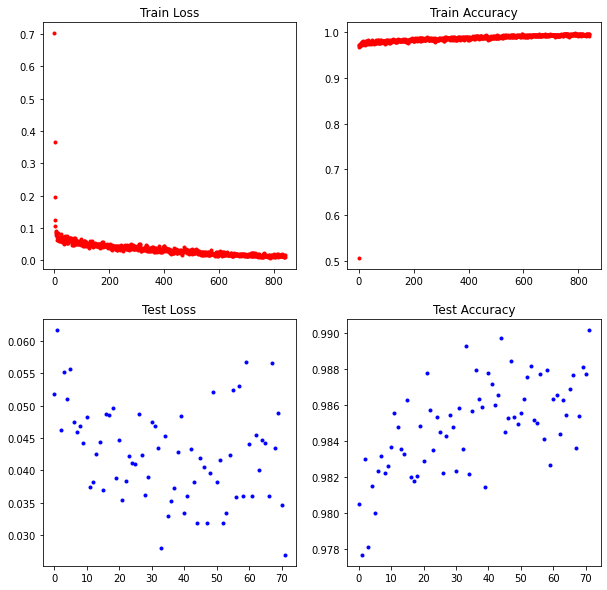

In [15]:
#Definisco i plots
train_results = defaultdict(list)
train_iter, test_iter, best_acc = 0,0,0
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
ax1.set_title('Train Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Test Loss')
ax4.set_title('Test Accuracy')

#dizionario f1 scores
f1_scores = defaultdict(list)

for i in trange(params["epochs"], desc='Epochs'):
    print("Epoch ",i)
    ## Train Phase
    #Model switches to train phase
    model.train() 
    
    #azzera ris
    all_outputs = []
    all_targets = []

    # Running through all mini batches in the dataset
    count, loss_val, correct, total = train_iter, 0, 0, 0
    for img_data, target in tqdm(train_loader, desc='Training'):  

        #load batch  
        img_data, target = img_data.to(device), target.to(device)

        #FWD prop
        output = model(img_data) 

        #Cross entropy loss
        loss = criterion(output, target) 

        #current loss 
        c_loss = loss.data.item()

        #plot current loss
        ax1.plot(count, c_loss, 'r.')

        #accumulate loss for training phase
        loss_val += c_loss

        optimizer.zero_grad() #Zero out any cached gradients
        loss.backward() #Backward pass
        optimizer.step() #Update the weights

        #number of outputs, batch * labels
        total_batch = (target.size(0) * target.size(1))
        total += total_batch

        #output and targets
        output_data = torch.sigmoid(output)>=0.5
        target_data = (target==1.0)
        
        #carica i risultati e i target
        for arr1,arr2 in zip(output_data, target_data):
            all_outputs.append(list(arr1.cpu().numpy()))
            all_targets.append(list(arr2.cpu().numpy()))

        #accuracy
        c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
        
        #plot accuracy
        ax2.plot(count, c_acc/total_batch, 'r.')

        #accumula accuracy
        correct += c_acc

        #accumula numero di steps per epoch
        count +=1
        
    #prendi i risultati dell'ultimo training
    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)

    #Training Metrics
    #______________________________________________________________________________________________________
    f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
    f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
    recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)
    
    f1_scores["samples_train"].append(f1score_samples)
    f1_scores["macro_train"].append(f1score_macro)
    f1_scores["weighted_train"].append(f1score_weighted)
    f1_scores["hamming_train"].append(hamming)
    #____________________________________________________________________________________________________________________
    #Training loss val è loss per image,
    #train_iter è count, numero di steps, images in training / batch size * epoch number
    #train_acc over training
    train_loss_val, train_iter, train_acc = loss_val/len(train_loader.dataset), count, correct/float(total)
    
    print("Training loss: ", train_loss_val, " train acc: ",train_acc)    
    ## Test Phase
    
    #Model switches to test phase
    model.eval()
    
    all_outputs = []
    all_targets = []
    #Running through all mini batches in the dataset
    count, correct, total, lost_val = test_iter, 0, 0, 0
    for img_data, target in tqdm(val_loader, desc='Validation'):
        img_data, target = img_data.to(device), target.to(device)
        output = model(img_data)
        loss = criterion(output, target) #Cross entropy loss
        c_loss = loss.data.item()
        ax3.plot(count, c_loss, 'b.')
        loss_val += c_loss
        #Compute accuracy
        #predicted = output.data.max(1)[1] #get index of max
        total_batch = (target.size(0) * target.size(1))
        total += total_batch
        output_data = torch.sigmoid(output)>=0.5
        target_data = (target==1.0)
        #print("Predictions: ", output_data)
        #print("Actual: ", target_data)
        for arr1,arr2 in zip(output_data, target_data):
            all_outputs.append(list(arr1.cpu().numpy()))
            all_targets.append(list(arr2.cpu().numpy()))
        c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
        ax4.plot(count, c_acc/total_batch, 'b.')
        correct += c_acc
        count += 1
    
    #print("Outputs: ", len(all_outputs), " x ", len(all_outputs[0]))
    #print("Targets: ", len(all_targets), " x ", len(all_targets[0]))
    
    #F1 Score
    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)
    f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
    f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
    recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)
    
    f1_scores["samples_test"].append(f1score_samples)
    f1_scores["macro_test"].append(f1score_macro)
    f1_scores["weighted_test"].append(f1score_weighted)
    f1_scores["hamming_test"].append(hamming)
    
    #Accuracy over entire dataset
    test_acc, test_iter, test_loss_val = correct/float(total), count, loss_val/len(test_loader.dataset)
    print("Test set accuracy: ",test_acc)
    print("f1_scores", f1_scores)
    train_results['epoch'].append(i)
    train_results['train_loss'].append(train_loss_val)
    train_results['train_acc'].append(train_acc)
    train_results['train_iter'].append(train_iter)
    
    train_results['test_loss'].append(test_loss_val)
    train_results['test_acc'].append(test_acc)
    train_results['test_iter'].append(test_iter)
    
    #Save model with best accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')
fig.savefig('train_curves.png')

In [16]:
PATH = "/content/drive/My Drive/RecipeNet/model/recipe1m_test.pt"


torch.save({
            'epoch': params["epochs"],
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'f1_scores': f1_scores,
            'train_results': train_results 
            }, PATH)


In [ ]:
#Loading:


PATH = "/content/drive/My Drive/RecipeNet/model/recipe1m_test.pt"
checkpoint = torch.load(PATH)

model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']

f1_scores = checkpoint['f1_scores']

train_results = checkpoint['train_results']


#***Evaluation***

In [ ]:
#Model switches to test phase
model.eval()

all_outputs = []
all_targets = []
#Running through all mini batches in the dataset
count, correct, total, lost_val = test_iter, 0, 0, 0
for img_data, target in tqdm(test_loader, desc='Testing'):
    img_data, target = img_data.to(device), target.to(device)
    output = model(img_data)
    loss = criterion(output, target) #Cross entropy loss
    c_loss = loss.data.item()
    ax3.plot(count, c_loss, 'b.')
    loss_val += c_loss
    #Compute accuracy
    #predicted = output.data.max(1)[1] #get index of max
    total_batch = (target.size(0) * target.size(1))
    total += total_batch
    output_data = torch.sigmoid(output)>=0.5
    target_data = (target==1.0)
    #print("Predictions: ", output_data)
    #print("Actual: ", target_data)
    for arr1,arr2 in zip(output_data, target_data):
        all_outputs.append(list(arr1.cpu().numpy()))
        all_targets.append(list(arr2.cpu().numpy()))
    c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
    correct += c_acc
    count += 1
#F1 Score
all_outputs = np.array(all_outputs)
all_targets = np.array(all_targets)
f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)

params["epochs"] -= 1
print("__________________TRAIN RESULTS______________________")
print("F1_samples", f1_scores["samples_train"][params["epochs"]])
print("F1_macro", f1_scores["macro_train"][params["epochs"]])
print("F1_weighted", f1_scores["weighted_train"][params["epochs"]])
print("Hamming Score",f1_scores["hamming_train"][params["epochs"]])

print("__________________VAL RESULTS______________________")
print("F1_samples", f1_scores["samples_test"][params["epochs"]])
print("F1_macro", f1_scores["macro_test"][params["epochs"]])
print("F1_weighted", f1_scores["weighted_test"][params["epochs"]])
print("Hamming Score",f1_scores["hamming_test"][params["epochs"]])


print("__________________TEST RESULTS______________________")
print("F1_samples", f1score_samples)
print("F1_macro", f1score_macro)
print("F1_weighted", f1score_weighted)
print("Recall",recall)
print("Precision",prec)
print("Hamming Score",hamming)